# Survival analysis on TCGA dataset

### Set instance and token

In [9]:
lapply(X = c('tidyverse', 'magrittr', 'integrationCurator', 'survival', 'survminer'),
       FUN = require, character.only = TRUE)

Sys.setenv(PRED_SPOT_HOST = 'odm-demos.genestack.com',
           PRED_SPOT_TOKEN = '<your token>', 
           PRED_SPOT_VERSION = 'default-released')

[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

### Get individuals from TCGA LUAD project

In [10]:
system.time({
  samples <-
    OmicsQueriesApi_search_samples(
      study_filter = '"genestack:accession"="GSF1061023"',
      sample_filter = 'Sex=male') %>%
    extract2('content') %>%
    extract2('data') %>%
    extract2('metadata')
    
}) %>% extract('elapsed') %>% signif(digits = 2) %>% paste('Time taken to get', nrow(samples), 'samples:', ., 'seconds.')

# Filter out NAs
samples %<>%
  as_tibble %>%
  filter(Survival != 'NA') %>%
  filter(Survival != 0) %>%
  select_if(~sum(!is.na(.)) > 0)
head(samples)

[1] "Time taken to get 242 samples: 0.28 seconds."

genestack:accession,Name,Sample Source ID,Organism,Sex,Disease,pack_years_smoked,Smoking Status,days_to_last_follow_up,primary_diagnosis,Race,case_id,Survival,Sample Source,Vital Status,Age at Index,days_to_death
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
GSF1061290,TCGA-NJ-A4YG,TCGA-NJ-A4YG,Homo sapiens,male,Adenocarcinoma with mixed subtypes,104,Yes,2261,Adenocarcinoma with mixed subtypes,white,7fd03220-531e-4ef8-beca-e9703e8c0ae1,2261,TCGA-LUAD,Alive,65,NA
GSF1061291,TCGA-55-8302,TCGA-55-8302,Homo sapiens,male,adenocarcinoma,59,Yes,478,"Adenocarcinoma, NOS",white,807cc7d2-6e3b-4f2d-9531-0da994eeeada,478,TCGA-LUAD,Alive,54,NA
GSF1061286,TCGA-86-8359,TCGA-86-8359,Homo sapiens,male,adenocarcinoma,36,Yes,26,"Adenocarcinoma, NOS",white,7e7f089c-25f7-4e14-aed5-d741047b9e42,444,TCGA-LUAD,Dead,52,444
GSF1061288,TCGA-50-7109,TCGA-50-7109,Homo sapiens,male,adenocarcinoma,120,Yes,255,"Adenocarcinoma, NOS",white,7eb540b4-8dd3-4382-a488-e48b1c7213b3,308,TCGA-LUAD,Dead,60,308
GSF1061287,TCGA-99-8032,TCGA-99-8032,Homo sapiens,male,adenocarcinoma,90,Yes,44,"Adenocarcinoma, NOS",white,7e83f9dd-b038-497b-a113-a55605398b7b,44,TCGA-LUAD,Alive,61,NA
GSF1061300,TCGA-86-8076,TCGA-86-8076,Homo sapiens,male,papillary adenocarcinoma,NA,No,993,"Papillary adenocarcinoma, NOS",white,8609edfc-119d-4d63-9188-c86aabd5ca52,993,TCGA-LUAD,Alive,42,NA


### Survival by smoking status

In [11]:
samples %>%
  group_by(`Smoking Status`) %>%
  summarise(mean(as.numeric(Survival))) %>%
  set_colnames(c('Smoker', 'Mean Survival (Days)'))

`summarise()` ungrouping output (override with `.groups` argument)



Smoker,Mean Survival (Days)
<chr>,<dbl>
No,933.1739
Yes,922.7771


### Get KRAS mutations

In [12]:
system.time({
  
  variants <-
    OmicsQueriesApi_search_variant_data(
      study_filter = '"genestack:accession"="GSF1061023"',
      sample_filter = 'Sex=male',
      vx_query = 'Gene=KRAS', 
      page_limit = 10000) %>%
    extract2('content') %>%
    extract2('data') %>%
    as_tibble
  
}) %>%
  extract('elapsed') %>% signif(digits = 3) %>% paste('Time taken to get', nrow(variants), 'genotypes:', ., 'seconds.')

variants %>% 
  mutate_at(c('alteration', 'variationId'), unlist) %>%
  print

[1] "Time taken to get 2534 genotypes: 3.98 seconds."

# A tibble: 2,534 x 12
   itemId metadata$`Exper… $`Data Processi… $`Genome Versio… $`Run Source ID`
   <chr>  <chr>            <chr>            <chr>            <chr>           
 1 66602… Illumina Genome… VarScan          GRCh38           TCGA-05-4244    
 2 66602… Illumina Genome… VarScan          GRCh38           TCGA-05-4249    
 3 66602… Illumina Genome… VarScan          GRCh38           TCGA-05-4382    
 4 66602… Illumina Genome… VarScan          GRCh38           TCGA-05-4389    
 5 66602… Illumina Genome… VarScan          GRCh38           TCGA-05-4395    
 6 66602… Illumina Genome… VarScan          GRCh38           TCGA-05-4396    
 7 66602… Illumina Genome… VarScan          GRCh38           TCGA-05-4397    
 8 66603… Illumina Genome… VarScan          GRCh38           TCGA-05-4420    
 9 66603… Illumina Genome… VarScan          GRCh38           TCGA-05-4424    
10 66604… Illumina Genome… VarScan          GRCh38           TCGA-05-4433    
# … with 2,524 more rows, and 14 more var

### Survival by KRAS mutation status

In [13]:
variants <- normaliseVariants(variants)

samples <- inner_join(samples, variants, by = 'Sample Source ID') 
samples %>%
  group_by(SNP) %>%
  summarise(mean(as.numeric(Survival))) %>%
  set_colnames(c('SNP', 'Mean Survival (Days)'))

`summarise()` ungrouping output (override with `.groups` argument)



SNP,Mean Survival (Days)
<chr>,<dbl>
No,949.1739
Yes,764.2951


### Get KRAS expression values

In [14]:
system.time({
  
  expression <-
    OmicsQueriesApi_search_expression_data(
      study_filter = '"genestack:accession"="GSF1061023"',
      sample_filter = 'Sex=male',
      ex_query = 'Gene=KRAS MinValue=0',
      ex_filter = 'Type=FPKM') %>%
    extract2('content') %>%
    extract2('data') %>%
    as_tibble
  
}) %>% extract('elapsed') %>% signif(digits = 3) %>% paste('Time taken to get', nrow(expression), 'expression values:', ., 'seconds.')

print(head(expression))

[1] "Time taken to get 219 expression values: 3.14 seconds."

# A tibble: 6 x 7
  itemId metadata$Type $`Run Source ID` runId groupId gene  expression
  <chr>  <chr>         <chr>            <chr> <chr>   <chr>      <dbl>
1 66554… FPKM          TCGA-05-4244     6655… GSF106… KRAS       12.4 
2 66554… FPKM          TCGA-05-4249     6655… GSF106… KRAS       31.6 
3 66554… FPKM          TCGA-05-4382     6655… GSF106… KRAS       10.7 
4 66554… FPKM          TCGA-05-4384     6655… GSF106… KRAS        9.37
5 66554… FPKM          TCGA-05-4389     6655… GSF106… KRAS        9.07
6 66554… FPKM          TCGA-05-4395     6655… GSF106… KRAS       17.1 
# … with 1 more variable: relationships$sample <chr>


### Survival by KRAS over/under expression

In [15]:
expression[, 2] <- expression$metadata$`Run Source ID`
colnames(expression)[2] <- 'Sample Source ID'

# Divide patients into two expression groups.
samples <- 
  inner_join(samples, expression, by = 'Sample Source ID') %>%
  { cbind(., 'regulation' = ifelse(.$expression > median(.$expression), 'Over', 'Under')) }

samples %>%
  group_by(regulation) %>%
  summarise(mean(as.numeric(Survival))) %>%
  set_colnames(c('Expression', 'Mean Survival (Days)'))

`summarise()` ungrouping output (override with `.groups` argument)



Expression,Mean Survival (Days)
<chr>,<dbl>
Over,795.4699
Under,961.7711


### Survival by KRAS copy number alterations

In [16]:
system.time({
  
  copy.number <-
    OmicsQueriesApi_search_expression_data(
      study_filter = '"genestack:accession"="GSF1061023"',
      sample_filter = 'Sex=male',
      ex_query = 'Gene=KRAS MinValue=0',
      ex_filter = 'Type="Copy Number"') %>%
    extract2('content') %>%
    extract2('data') %>%
    as_tibble
  
}) %>% extract('elapsed') %>% signif(digits = 3) %>% paste('Time taken to get', nrow(copy.number), 'copy number values:', ., 'seconds.')

copy.number[, 2] <- copy.number$metadata$`Run Source ID`
colnames(copy.number)[2] <- 'Sample Source ID'
samples <-
  inner_join(samples, copy.number, by = 'Sample Source ID') %>%
  { cbind(., 'copies' = ifelse(.$expression.y >4, 'High CNA', 'Low CNA')) }

samples %>%
  group_by(copies) %>%
  summarise(mean(as.numeric(Survival))) %>%
  set_colnames(c('Copy Number Abberation', 'Mean Survival (Days)'))

[1] "Time taken to get 217 copy number values: 3.27 seconds."

`summarise()` ungrouping output (override with `.groups` argument)



Copy Number Abberation,Mean Survival (Days)
<chr>,<dbl>
High CNA,611.5556
Low CNA,959.6032


### Survival curve for based on smoking status and multi-omics marker 

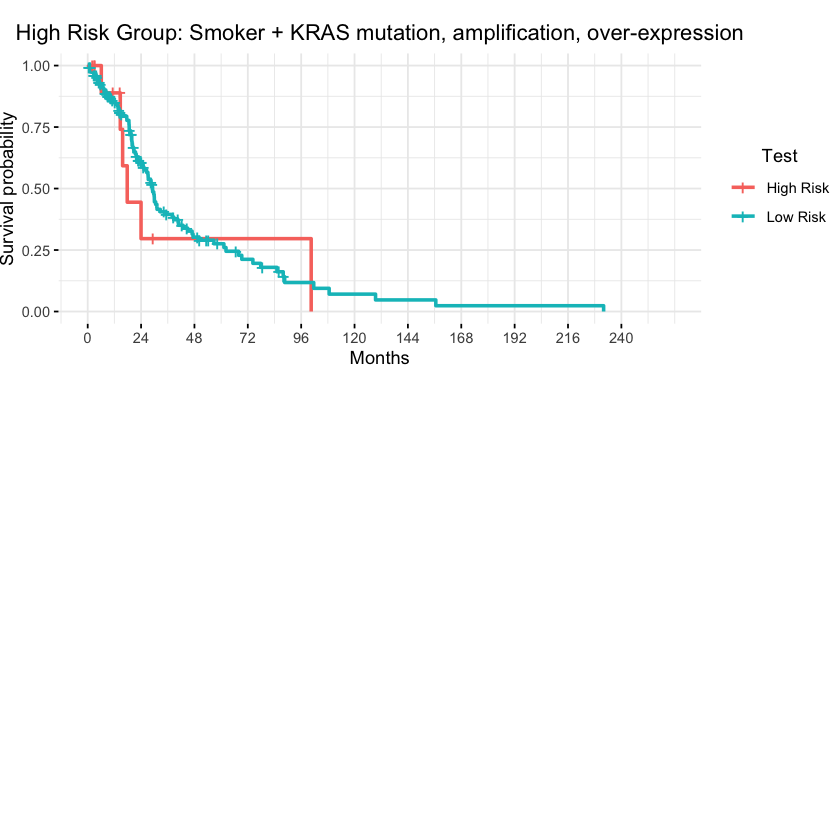

In [17]:
risk_group <-
  apply(X = samples, MARGIN = 1, FUN = function(x) {
    if ( sum(x['Smoking Status'] == 'Yes', 
             x['SNP'] == 'Yes', 
             x['regulation'] == 'Over', 
             x['copies'] == 'High CNA') == 4 ) { 'High' } else { 'Low' }
  })
# Quick stratification of patients into high and low-risk groups.
data <- {
  samples %>%
    { data.frame(as.numeric(.[, 'Survival']),
                 ifelse(.[, 'Vital Status'] == 'Dead', 0, 1),
                 risk_group) } %>%
    `colnames<-`(c('Time', 'Status', 'Risk'))
}
fit <- { 
  survfit(formula = Surv(time = Time, event = Status) ~ Risk,
                 data = data) }
# Compute Kaplan-Meier curve data for binary risk groups.
ggsurvplot(fit = fit,
           data = data,
           xscale = 'd_m',
           break.x.by = 730.5,
           xlab = 'Months',
           legend = 'right',
           legend.title = 'Test',
           legend.labs = c('High Risk', 'Low Risk'),
           ggtheme = theme_minimal() +
             theme(plot.title = element_text(hjust = 0.5), plot.margin = unit(c(0.5,0,10,0),"cm"),
                   legend.title.align = 0.5)) +
  labs(title = paste('High Risk Group: Smoker + KRAS mutation, amplification, over-expression'))
# Plot survival curve for multi-omics stratification groups.

In [18]:
normaliseVariants <- function(variants) {
  variants$genotype$GT %<>% { ifelse(test = . == './.', yes = '0/0', no = .) }
    
  # Assume genotype 0/0 for no information.
  normalisedVariants = lapply(X = unique(variants$start), FUN = function(rs) {
    
    SNP <- dplyr::filter(variants, start == rs)
    # Filter the table down to just one SNP at a time.
    
    if ( length(unique(SNP$genotype$sampleNames)) != nrow(SNP) ) {
      # If the number of rows and number of unique sample IDs don't match:
      
      
      lapply(X = unique(SNP$genotype$sampleNames), FUN = function(patient) {
        
        dplyr::filter(SNP$genotype, sampleNames == patient) %>%
          dplyr::select(GT) %>%
          table %>%
          { if ( length(.) == 1 ) { return(c('SNP' = rs, 'sampleNames' = patient, 'GT' = '0/0')) }
            else if ( length(.) == 2 ) { return(c('SNP' = rs, 'sampleNames' = patient, 'GT' = '0/1')) }
            else if ( length(.) == 3 ) { return(c('SNP' = rs, 'sampleNames' = patient, 'GT' = '1/1')) }}
        # Rough and ready way to compress multiple base variants for the same SNP.
        
      }) %>%
        do.call('rbind', .)
      
    } else { 
      
      cbind(rs, SNP$genotype[, c('sampleNames', 'GT')]) %>%
        set_colnames(c('SNP', 'sampleNames', 'GT')) %>%
        return
      
    }
    
  }) %>%
  do.call('rbind', .) %>%
  { lapply(X = unique(.$sampleNames), 
           FUN = function(patient) {
             
             dplyr::filter(., sampleNames == patient) %>%
               dplyr::select(GT) %>%
               unlist %>%
               { if ( all(. == '0/0') ) { c('Sample Source ID' = patient, 'SNP' = 'No') } else { c('Sample Source ID' = patient, 'SNP' = 'Yes') } }
               
           }) } %>%
  do.call('rbind', .) %>%
  as_tibble
    
    return(normalisedVariants)
}